In [1]:
#Imports
import numpy as np
import sklearn as sk
import edward as ed
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup plotting
%matplotlib inline
np.random.seed(sum(map(ord, 'aesthetics')))
sns.set_style('ticks')
sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2.5})

# Setup Edward
#ed.set_seed(42)

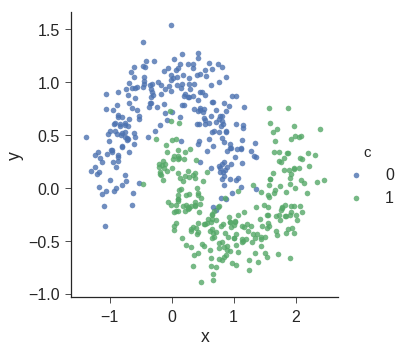

In [2]:
# Build a toy dataset
def build_toy_dataset(N=1000, noise=0.2):
    from sklearn import datasets
    from sklearn import model_selection
    X, Y = datasets.make_moons(noise=noise, random_state=0, n_samples=N)
    x_tr, x_te, y_tr, y_te = model_selection.train_test_split(X, Y, test_size=.5)
    return x_tr, x_te, y_tr, y_te

X_train, X_test, Y_train, Y_test = build_toy_dataset()
d = pd.DataFrame.from_records([[p[0], p[1], c] for p, c in zip(X_train, Y_train)], columns=['x','y','c'])
sns.lmplot(data=d, x='x', y='y', hue='c', fit_reg=False)
plt.show()
Y_train = [[1, 0] if i ==0 else [0, 1] for i in Y_train]
Y_test = [[1, 0] if i ==0 else [0, 1] for i in Y_test]

In [3]:
# Setup Neural Network
class MultilayerPerceptron:    
    def __init__(self, session, ninputs, nclasses, layerconfig):
        '''Initialize the tf graph corresponding to the multilayer preceptron'''
        self.session = session
        self.inputs = tf.placeholder(tf.float32, [None, ninputs])
        self.true_outputs = tf.placeholder(tf.float32, [None, nclasses])
        n = [ninputs] + layerconfig + [nclasses]
        self.w = [tf.Variable(tf.random_normal([n[i], n[i+1]])) for i in range(0, len(n)-1)]
        self.b = [tf.Variable(tf.random_normal([l])) for i,l in enumerate(n[1:])]
        self.model = self._construct_network(self.inputs, self.w, self.b)
        self.trained = False
    
    def _construct_network(self, x, w, b):
        '''Construct the tf graph'''
        xi = x
        for i, (wi, bi) in enumerate(zip(w, b)):
            xi = tf.nn.relu(tf.matmul(xi, wi) + bi)
        return tf.nn.softmax(xi)
        
    def train(self, X, Y, epochs=100, batch_size=100):
        '''Train the multilayer peceptron'''
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.model, labels=self.true_outputs))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
        init = tf.global_variables_initializer()
        self.session.run(init)
        for epoch in range(epochs):
            avg_cost = 0.
            total_batch = int(len(X)/batch_size)
            for batch_x, batch_y in zip(np.array_split(X, total_batch), np.array_split(Y, total_batch)):
                _, c = self.session.run([optimizer, cost], feed_dict={self.inputs: batch_x, self.true_outputs: batch_y})
                avg_cost += c / total_batch
            if epoch % 1000 == 0:
                print('Epoch:', '%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))
        self.trained = True
        
    def _test(self, X, Y, models):
        predictions = tf.stack([tf.argmax(model, 1) for model in models])
        correct = tf.equal(predictions, tf.stack([tf.argmax(self.true_outputs, 1) for _ in models]))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'), 1)*100
        p, c, a = self.session.run([predictions, correct, accuracy], {self.inputs: X, self.true_outputs: Y})
        return (p, c, a)
    
    def test(self, X, Y):
        '''Generate outputs for the neural network under trained params'''
        if not self.trained:
            pass
        return self._test(X, Y, [self.model])
    
    def inject_and_test(self, X, Y, targetlayer, ninjections=100):
        '''Create a bayesian neural network corresponding to the injection'''
        if not self.trained:
            pass
        # Make new model
        old_shape = self.w[targetlayer].shape
        injection_w = [ed.models.PointMass(params=w) if i != targetlayer
                       else ed.models.Normal(loc=w, scale=tf.ones(w.shape))
                       for i, w in enumerate(self.w)]
        injection_b = self.b
        injection_models = [self._construct_network(self.inputs, [w.sample() for w in injection_w], injection_b) for _ in range(ninjections)]
        # Test
        return self._test(X, Y, injection_models)
    
    def inject_values(self, var, session, value):
        '''Inject values in particular weights of the network'''
        op = tf.assign(var, value)
        session.run(op)

Epoch: 0001 cost= 0.797360837
Epoch: 1001 cost= 0.344901562
Epoch: 2001 cost= 0.334583133
Epoch: 3001 cost= 0.332157969
Epoch: 4001 cost= 0.330652863
Epoch: 5001 cost= 0.329345763
Epoch: 6001 cost= 0.327865481
Epoch: 7001 cost= 0.326733351
Epoch: 8001 cost= 0.325823307
Epoch: 9001 cost= 0.324969918
Accuracy [95.]


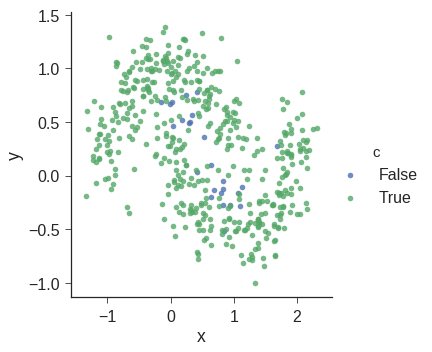

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


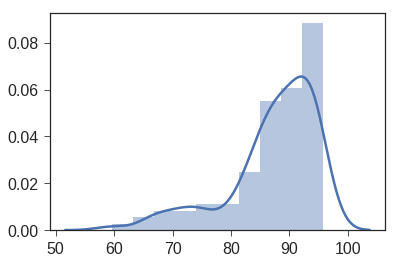

In [5]:
with tf.Session() as sess:
    # Train network
    net = MultilayerPerceptron(sess, 2, 2, [10, 10])
    net.train(X_train, Y_train, 10000, 300)
   
    # Test network
    predictions, correct, accuracy = net.test(X_test, Y_test)
    print('Accuracy', accuracy)
    sns.lmplot(data=pd.DataFrame.from_records([[point[0], point[1], pred, correct] for point, pred, correct in zip(X_test, predictions[0], correct[0])], columns=['x','y','p', 'c']), x='x', y='y', hue='c', fit_reg=False)
    plt.show()
    
    # Inject
    predictions, correct, accuracies = net.inject_and_test(X_test, Y_test, 1, 100)
    sns.distplot(accuracies)
    plt.show()